# Product Allocation and Functional Area Sizing
- Product Allocation and Functional Area Sizing (Min. Cost) (5pts)
- Block Layout Design (6 Departments) (5pts)
    -   (Optional) Robust Block Layout Design (All departments) (Bonus 2.5pts)

In [4]:

import pandas as pd
import math
import pulp
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from collections import defaultdict


In [3]:
"""
In this part of the code we import all the data into dataframes
"""

# Define product data
requirements = {
    "Product": ["Product 1", "Product 2", "Product 3", "Product 4", "Product 5", "Product 6"],
    "Annual demand (units)": [10000, 15000, 25000, 2000, 1500, 95000],
    "Order cost ($)": [50, 50, 50, 50, 50, 150],
    "Price/unit load ($)": [500, 650, 350, 250, 225, 150],
    "Space required (m²)": [10, 15, 25, 10, 12, 13],
    "Reserve dwell percentage (%)": [0, 0, 0.20, 0, 0, 1.00],
    "Yearly carrying cost rate (%)": [0.10, 0.10, 0.10, 0.10, 0.10, 0.10]
}

# Define flow data
flow_cost = {
    "Flow/Product": ["Flow 1 (CD)", "Flow 2 (R)", "Flow 3 (RF)", "Flow 4 (F)"],
    "Product 1": [0.0707, 0.0849, 0.1061, 0.0778],
    "Product 2": [0.0203, 0.2023, 0.2023, 0.2023],
    "Product 3": [0.0267, 0.0420, 0.0054, 0.0481],
    "Product 4": [0.3354, 0.5590, 1.0062, 0.0671],
    "Product 5": [0.4083, 0.6804, 1.2248, 0.8165],
    "Product 6": [0.0726, 0.0871, 0.1088, 0.0798]
}


# Define flow data (integer version)
yearly_cost = {
    "Flow/Product": ["Flow 1 (CD)", "Flow 2 (R)", "Flow 3 (RF)", "Flow 4 (F)"],
    "Product 1": [20, 5, 10, 15],
    "Product 2": [15, 5, 10, 10],
    "Product 3": [4, 20, 1, 9],
    "Product 4": [5, 4, 5, 1],
    "Product 5": [15, 25, 45, 30],
    "Product 6": [20, 5, 10, 15]
}

area_bounds = {
    "Functional Area": ["Cross-docking", "Reserve", "Forward"],
    "Lower bound (m²)": [0, 35000, 35000],
    "Upper bound (m²)": [15000, 75000, 75000]
}

levels = {
    "Functional Area": ["Cross-docking", "Reserve", "Forward"],
    "#Levels": [1, 1, 1]
}

area_bounds = pd.DataFrame(area_bounds)
levels = pd.DataFrame(levels)
yearly_cost = pd.DataFrame(yearly_cost)
flow_cost = pd.DataFrame(flow_cost)
requirements  = pd.DataFrame(requirements)


In [4]:
"""
In this part of the code we calculate the EOQ and average dwell time for each product usin the
formulas from the slides
"""


eoq = [] 
avg_dwell = []
for i, row in requirements.iterrows():  # iterate over rows
    demand = row["Annual demand (units)"]
    order_cost = row["Order cost ($)"]
    price = row["Price/unit load ($)"]
    carrying_rate = row["Yearly carrying cost rate (%)"]

    eoq_val = math.sqrt((2 * demand * order_cost) / (price * carrying_rate))
    eoq.append(eoq_val)
    avg_dwell_time = eoq_val /(2 * demand)
    avg_dwell.append(avg_dwell_time)

# Add EOQ as a new column to the DataFrame
requirements["EOQ"] = eoq
requirements["Avg dwell time"] = avg_dwell

print(requirements[["Product", "EOQ", "Avg dwell time"]])


     Product          EOQ  Avg dwell time
0  Product 1   141.421356        0.007071
1  Product 2   151.910905        0.005064
2  Product 3   267.261242        0.005345
3  Product 4    89.442719        0.022361
4  Product 5    81.649658        0.027217
5  Product 6  1378.404875        0.007255


## Mathematical formulation
### Sets
- $ I \in \{1,2,3,4,5,6\} $ are products which need to be stored in the warehouse.
- $ J \in \{1,2,3,4\} $ are the different flows going trough the warehouse


### Parameters
- $S^{total}$       - Total availibale stoage space ($100.000m^2$)
- $S_{i}$           - Space required for storing a unit of product i
- $z^{CD}$          - Levels of space available in the vertical dimention of functional area Cross Docking
- $z^{F}$           - Levels of space available in the vertical dimention of functional area Forward
- $z^{R}$           - Levels of space available in the vertical dimention of functional area Reserve
- $LL_{CD}$         - Lower storage space limit in the in cross docking $(0m^2)$
- $UL_{CD}$         - Upper storage space limit in the in cross docking $(15000m^2)$
- $LL_{F}$          - Lower storage space limit in the in forward $(35000m^2)$
- $UL_{F}$          - Upper storage space limit in the in forward $(75000m^2)$
- $LL_{R}$          - Lower storage space limit in the in reserve $(35000m^2)$
- $UL_{R}$          - Upper storage space limit in the in reserve $(75000m^2)$
- $C_{ij}^{handle}$ - Cost of handeling a unit load of product i and material flow j
- $C_{ij}^{store}$  - Cost of storing a unit load of product i and material flow j
- $\rho_{i}^R$      - Average percentage of time a unit load of product i spends in the reserve area if product is assigned to material flow 3
        


### Decision variables

- $
x_{ij} = 
\begin{cases}
\text{1}, & \text{if product i is assigned to flow j} \\
\text{0}, & \text{@}
\end{cases}
$
- $w^{CD}$ Propotion of available space assigned to the crossing dock function area
- $w^{F}$ Propotion of available space assigned to the forward function area
- $w^{R}$ Propotion of available space assigned to the reserve function area

### Objective function
$$
min \sum_{i=1}^6 \sum_{j=1}^4 (2C_{ij}^{handle})D_ix_{ij}+ \sum_{i=1}^6 \sum_{j=1}^4 \frac{Q_i}{2}C_{ij}^{store}x_{ij}
$$
Same as in the lecture slides of this course, we assume for all flow only 2 transactions. Therefore, we only have the coefficient 2 here.

### Constraints
Since we assign each product to one flow this will add up to one for all the flows combined combined with the fact that x is binary this function will work.
$$
\sum_{j}^4 x_{ij} = 1 \quad \forall i \in I
$$
Since the cross docking only happens in flow 1:
$$
\sum_{i=1}^6\frac{Q_i}{2}S_ix_{i1} \le w^{CD}(z^{CD}S^{total}) 
$$
Since the reserve only goes trough flow 2 and 3 the sum of these two sould be less than propotion of availbe space times the total space (vertial and in floor area). 
$$
\sum_{i=1}^6\frac{Q_i}{2}S_ix_{i2} + \sum_{i=1}^6\frac{Q_i}{2}\rho_{i}^RS_ix_{i3}\le w^{R}(z^{R}S^{total}) 
$$
Since the forward only goes trough flow 3 and 4 the sum of these two sould be less than propotion of availbe space times the total space (vertial and in floor area). 
$$
\sum_{i=1}^6\frac{Q_i}{2}(1-\rho_{i}^R)S_ix_{i3} + \sum_{i=1}^6\frac{Q_i}{2}S_ix_{i4}\le w^{F}(z^{F}S^{total}) 
$$
A 100% of the space should be allocated
$$
w^{CD} + w^R + w^F = 1
$$
The lower and upper limits given should be enforced
$$
LL_{CD} \le w^{CD}(z^{CD}S^{total}) \le UL_{CD}
LL_{R} \le w^{R}(z^{R}S^{total}) \le UL_{R}
LL_{F} \le w^{F}(z^{F}S^{total}) \le UL_{F}
$$
Proportion should be smaller than the avaible space
$$
w^{CD}, w^{R}, w^F \ge 0
$$

In [1]:
# Sets
products = requirements["Product"].tolist()  # I
flows = flow_cost["Flow/Product"].tolist()  # J

# Parameters
S_total = 100000
S = requirements.set_index("Product")["Space required (m²)"].to_dict()  # space per product
Q = dict(zip(requirements["Product"], requirements["EOQ"]))  # EOQ per product
C_handle = flow_cost.set_index("Flow/Product").T.to_dict()  # handling cost per product per flow
C_store = yearly_cost.set_index("Flow/Product").T.to_dict()  # storage cost per product per flow
rho_R = requirements.set_index("Product")["Reserve dwell percentage (%)"].to_dict()  # proportion to reserve

# Vertical levels
z_CD = levels.set_index("Functional Area").loc["Cross-docking", "#Levels"]
z_F = levels.set_index("Functional Area").loc["Forward", "#Levels"]
z_R = levels.set_index("Functional Area").loc["Reserve", "#Levels"]

# Limits
LL_CD, UL_CD = area_bounds.set_index("Functional Area").loc["Cross-docking", ["Lower bound (m²)", "Upper bound (m²)"]]
LL_F, UL_F = area_bounds.set_index("Functional Area").loc["Forward", ["Lower bound (m²)", "Upper bound (m²)"]]
LL_R, UL_R = area_bounds.set_index("Functional Area").loc["Reserve", ["Lower bound (m²)", "Upper bound (m²)"]]

# Create model
model = pulp.LpProblem("Warehouse_Storage_Optimization", pulp.LpMinimize)

# Decision variables
x = pulp.LpVariable.dicts("x", [(i,j) for i in products for j in flows], cat='Binary')
w_CD = pulp.LpVariable("w_CD", lowBound=0)
w_F  = pulp.LpVariable("w_F", lowBound=0)
w_R  = pulp.LpVariable("w_R", lowBound=0)

# Objective function
total_cost = pulp.lpSum([
    (2 * C_handle[j][i] * Q[i] * x[i,j]) +
    (Q[i]/2 * C_store[j][i] * x[i,j])
    for i in products for j in flows
])

# Add to objective
model += total_cost
# Constraints

# Each product assigned to exactly one flow
for i in products:
    model += pulp.lpSum([x[i,j] for j in flows]) == 1

# Cross Docking (Flow 1)
model += pulp.lpSum([Q[i]/2 * S[i] * x[i,'Flow 1 (CD)'] for i in products]) <= w_CD * z_CD * S_total

# Reserve (Flow 2 and Flow 3)
model += pulp.lpSum([Q[i]/2 * S[i] * x[i,'Flow 2 (R)'] + Q[i]/2 * rho_R[i] * S[i] * x[i,'Flow 3 (RF)'] for i in products]) <= w_R * z_R * S_total

# Forward (Flow 3 and Flow 4)
model += pulp.lpSum([Q[i]/2 * (1-rho_R[i]) * S[i] * x[i,'Flow 3 (RF)'] + Q[i]/2 * S[i] * x[i,'Flow 4 (F)'] for i in products]) <= w_F * z_F * S_total

# 100% of the space allocated
model += w_CD + w_R + w_F == 1

# Enforce lower and upper limits
model += w_CD * z_CD * S_total >= LL_CD
model += w_CD * z_CD * S_total <= UL_CD
model += w_R * z_R * S_total >= LL_R
model += w_R * z_R * S_total <= UL_R
model += w_F * z_F * S_total >= LL_F
model += w_F * z_F * S_total <= UL_F

# Solve the model
model.solve()

# Output results
print("Product Allocations:")
for i in products:
    for j in flows:
        if x[i,j].value() == 1:
            print(f"{i}: {j}")
print()
print("Area Sizes:")
print(f"Cross Docking: {w_CD.value()*S_total}m²")
print(f"Reserve: {w_R.value()*S_total}m²")
print(f"Forward: {w_F.value()*S_total}m²")
print()
print("Total cost:", round(pulp.value(total_cost), 2))



NameError: name 'requirements' is not defined

# 11.5 Warehouse Block Layout Design

In [17]:


# Example: access a value
#print(departments["Cross-Dock"])  # Output: 3520
departments_matrix = {
    "Inbound Dock": {
        "Inbound Dock": "-",
        "Receiving/Staging": "E",
        "QA & Technical Test": "U",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "U",
        "Outbound Staging": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Receiving/Staging": {
        "Inbound Dock": "E",
        "Receiving/Staging": "-",
        "QA & Technical Test": "A",
        "Cross-Dock": "A",
        "Pallet Reserve Storage (Bulk)": "I",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "U",
        "Outbound Staging": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "I",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "QA & Technical Test": {
        "Inbound Dock": "U",
        "Receiving/Staging": "A",
        "QA & Technical Test": "-",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "U",
        "Outbound Staging": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "I",
        "Spare Parts & Accessories Cage": "U"
    },
    "Cross-Dock": {
        "Inbound Dock": "U",
        "Receiving/Staging": "A",
        "QA & Technical Test": "U",
        "Cross-Dock": "-",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "U",
        "Outbound Staging": "A",
        "Shipping Dock": "A",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Pallet Reserve Storage (Bulk)": {
        "Inbound Dock": "U",
        "Receiving/Staging": "I",
        "QA & Technical Test": "U",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "-",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "E",
        "Outbound Staging": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "O",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Oversize/Non-Standard Storage": {
        "Inbound Dock": "U",
        "Receiving/Staging": "U",
        "QA & Technical Test": "U",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "-",
        "Packing / Wrap / Banding": "I",
        "Outbound Staging": "U",

        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Packing / Wrap / Banding": {
        "Inbound Dock": "U",
        "Receiving/Staging": "U",
        "QA & Technical Test": "U",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "E",
        "Oversize/Non-Standard Storage": "I",
        "Packing / Wrap / Banding": "-",
        "Outbound Staging": "E",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "O",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "O",
        "Spare Parts & Accessories Cage": "U"
    },
    "Outbound Staging": {
        "Inbound Dock": "U",
        "Receiving/Staging": "U",
        "QA & Technical Test": "U",
        "Cross-Dock": "A",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "E",
        "Outbound Staging": "-",
        "Shipping Dock": "E",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Shipping Dock": {
        "Inbound Dock": "U",
        "Receiving/Staging": "U",
        "QA & Technical Test": "U",
        "Cross-Dock": "A",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "U",
        "Outbound Staging": "E",
        "Shipping Dock": "-",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Empty Pallets & Dunnage": {
        "Inbound Dock": "U",
        "Receiving/Staging": "I",
        "QA & Technical Test": "U",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "O",
        "Outbound Staging": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "-",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Maintenance & Battery Charge": {
        "Inbound Dock": "U",
        "Receiving/Staging": "U",
        "QA & Technical Test": "U",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "O",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "U",
        "Outbound Staging": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "-",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Returns & WEEE": {
        "Inbound Dock": "U",
        "Receiving/Staging": "U",
        "QA & Technical Test": "I",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "O",
        "Outbound Staging": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "-",
        "Spare Parts & Accessories Cage": "U"
    },
    "Spare Parts & Accessories Cage": {
        "Inbound Dock": "U",
        "Receiving/Staging": "U",
        "QA & Technical Test": "U",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "U",
        "Outbound Staging": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "-"
    }
}

# Define the mapping of letters to numeric values
letter_to_number = {
    "E": 4,
    "A": 3,
    "I": 2,
    "O": 1,
    "U": 0,
    "-": 0 
}
# Selected six departments 
def load_data():
    selected_depts = [  
        "Inbound Dock",
        "Outbound Staging",
        "Packing / Wrap / Banding",
        "Pallet Reserve Storage (Bulk)",
        "Receiving/Staging",
        "Shipping Dock"
    ]
    return selected_depts

departments = {
    "Cross-Dock": 3520,
    "Empty Pallets & Dunnage": 880,
    "Inbound Dock": 2640,
    "Maintenance & Battery Charge": 1320,
    "Outbound Staging": 8800,
    "Oversize/Non-Standard Storage": 2640,
    "Packing / Wrap / Banding": 3520,
    "Pallet Reserve Storage (Bulk)": 46340,
    "QA & Technical Test": 1760,
    "Receiving/Staging": 5280,
    "Returns & WEEE": 2640,
    "Shipping Dock": 3520,
    "Spare Parts & Accessories Cage": 440
}

# Example: access a value   
#print(departments_matrix["Inbound Dock"]["Receiving/Staging"])  # Output: E

In [20]:
# Function to convert nested dictionary values
def convert_letters_to_numbers(matrix, mapping):
    numeric_matrix = {}
    for dept_from, relations in matrix.items():
        numeric_matrix[dept_from] = {}
        for dept_to, letter in relations.items():
            numeric_matrix[dept_from][dept_to] = mapping.get(letter, None)  # None if unknown
    return numeric_matrix
# Apply the conversion
numeric_departments_matrix = convert_letters_to_numbers(departments_matrix, letter_to_number)
# Example: check numeric value

print(numeric_departments_matrix["Inbound Dock"]["Receiving/Staging"])  # Output: 3
print(numeric_departments_matrix["Inbound Dock"]["Inbound Dock"])      # Output: -1

4
0


In [22]:
def convert_letters_to_numbers(matrix, mapping):
    numeric_matrix = {}
    for dept_from, relations in matrix.items():
        numeric_matrix[dept_from] = {}
        for dept_to, letter in relations.items():
            val = mapping.get(letter, None)
            numeric_matrix[dept_from][dept_to] = val**2 if val is not None else None
    return numeric_matrix

numeric_departments_matrix = convert_letters_to_numbers(departments_matrix, letter_to_number)

print(numeric_departments_matrix["Inbound Dock"]["Receiving/Staging"])  # Output: 9
print(numeric_departments_matrix["Inbound Dock"]["Inbound Dock"])      # Output: 0


16
0


## Mathematical formulation
We consider the following 6 departments
- Inbound Dock
- Receiving/Staging
- Pallet Reserve Storage (Bulk)
- Packing / Wrap / Banding
- Outbound Staging (Join areas for 2-Man Delivery and Parcel)
- Shipping Dock
### Sets
- $ I \in \{1,2,3,4,5,6\} $ are the 6 departments
- $ J \in \{1,2,3,4,5,6\} $ are the 6 departments


### Parameters

- $m$                   - Number of departments 
- $f_{ij}$              - Flow from department $i$ to department $j$ 
- $c_{ij}$              - Cost of moving a unit load one distance unit from department $i$ to department $j$
- $B_x$                 - Building length (measured along the x-coordinate)
- $B_y$                 - Building width (measured along the y-coordinate)
- $A_i$                 - Area of department $i$
- $L_{i}^{\text{LB}}$   - Lower limit on the length of department $i$
- $L_{i}^{\text{UB}}$   - Upper limit on the length of department $i$
- $W_{i}^{\text{LB}}$   - Lower limit on the width of department $i$
- $W_{i}^{\text{UB}}$   - Upper limit on the width of department $i$
- $M$                   - Large number 


### Variables
- $\alpha_i$: x-coordinate of the centroid of department $i$
- $\beta_i$: y-coordinate of the centroid of department $i$
- $x_{i}^{\text{left}}$: x-coordinate of the left (or west) side of department $i$
- $x_{i}^{\text{right}}$: x-coordinate of the right (or east) side of department $i$
- $y_{i}^{\text{bottom}}$: y-coordinate of the bottom (or south) side of department $i$
- $y_{i}^{\text{top}}$: y-coordinate of the top (or north) side of department $i$
- $z_{ij}^{x}$: 1 if department $i$ is strictly to the east of department $j$; 0 otherwise
- $z_{ij}^{y}$: 1 if department $i$ is strictly to the north of department $j$; 0 otherwise





### Objective function

$$
\min \sum_{i=1}^6 \sum_{j=1}^6 f_{ij} c_{ij} (|\alpha_i - \alpha_j| + |\beta_i - \beta_j|)
$$


### Constraints 
The length and width of each department must remain within the specified bounds:

Length Constraints:
$$
L_i^{\text{LB}} \leq (x_i^{\text{right}} - x_i^{\text{left}}) \leq L_i^{\text{UB}} \quad \forall i \in I
$$

Width Constraints:
$$
W_i^{\text{LB}} \leq (y_i^{\text{top}} - y_i^{\text{bottom}}) \leq W_i^{\text{UB}} \quad \forall i \in I
$$


Area Constraints:
$$
(x_i^{\text{right}} - x_i^{\text{left}})(y_i^{\text{top}} - y_i^{\text{bottom}}) = A_i \quad \forall i \in I
$$


X-Direction Boundaries:
$$
0 \leq x_i^{\text{left}} \leq x_i^{\text{right}} \leq B_x \quad \forall i \in I
$$

Y-Direction Boundaries:
$$
0 \leq y_i^{\text{bottom}} \leq y_i^{\text{top}} \leq B_y \quad \forall i \in I
$$

X-Coordinate Centroid:
$$
\alpha_i = 0.5x_{i}^{\text{left}} + 0.5x_{i}^{\text{right}} \quad \forall i \in I
$$

Y-Coordinate Centroid:
$$
\beta_i = 0.5y_{i}^{\text{bottom}} + 0.5y_{i}^{\text{top}} \quad \forall i \in I
$$

East-West Separation:
$$
x_j^{\text{right}} \leq x_i^{\text{left}} + M(1 - z_{ij}^x) \quad \forall i,j, i \neq j
$$

North-South Separation:
$$
y_j^{\text{top}} \leq y_i^{\text{bottom}} + M(1 - z_{ij}^y) \quad \forall i,j, i \neq j
$$

Mutual Exclusion:
$$
z_{ij}^x + z_{ji}^x + z_{ij}^y + z_{ji}^y \geq 1 \quad \forall i,j, i \leq j
$$


Continuous Variable Non-negativity:
$$
\alpha_i, \beta_i \geq 0 \quad \forall i
$$

Boundary Variable Non-negativity:
$$
x_{i}^{\text{left}}, x_{i}^{\text{right}}, y_{i}^{\text{bottom}}, y_{i}^{\text{top}} \geq 0 \quad \forall i
$$

Binary Variable Declaration:
$$
z_{ij}^{x}, z_{ij}^{y} \in \{0, 1\} \quad \forall i,j, i \neq j
$$

## Code


<font size="5">
Side Notes
</font>

**Coverting Qualitative SLP**
We converted the qualitative SLP to a quanitive one by using the SLP legend. in this case it was possible as 'X' was not given in the SLP adjacent matrix and we therefore, also do not make use of negative numbers. 

**Outbound Staging** <br>
For the outbound strategy we where suppose to ioin areas for 2-Man Delivery and Parcel. We have done this by adding their areas together. Additionally, for the interaction we compared if they have for all departments the same value. As this was the case, we used these values for a department called 'Outbound Staging' and took out the departments for 2-Man Delivery and Parcel.

**Aspect Ratio**<br>
We make use of an aspect ratio, for giving the warehouse certain proportions. 'R' is used for the proportion of the departments and 'I' is used for the general shape of the I-shaped warehouse.

**Clearance**<br>
As we limit our warehouse size to the sum of the area needed by each deaprtment, we do not make use of clearance. Otherwise our model would be infeasable as a larger area would be needed.

**Phantom Department** <br>
In order to create L- and U- shaped warehouses, we introduced a phantom warehouse. For this department we added a consraint which defined on which wall (s) it should be placed to reach the wanted shape. The exact size of the phantom warehouse then depends on width and the height of the total warehouse.

**Costs** <br>
As no costs have been specified in the assignment describtion, we chose to set c to 1. Therefore, we left it out in our objective unction in the gurobi model below.

Set parameter NonConvex to value 2


Inbound Dock Inbound Dock
Inbound Dock Outbound Staging
Inbound Dock Packing / Wrap / Banding
Inbound Dock Pallet Reserve Storage (Bulk)
Inbound Dock Receiving/Staging
Inbound Dock Shipping Dock
Inbound Dock Phantom
Outbound Staging Inbound Dock
Outbound Staging Outbound Staging
Outbound Staging Packing / Wrap / Banding
Outbound Staging Pallet Reserve Storage (Bulk)
Outbound Staging Receiving/Staging
Outbound Staging Shipping Dock
Outbound Staging Phantom
Packing / Wrap / Banding Inbound Dock
Packing / Wrap / Banding Outbound Staging
Packing / Wrap / Banding Packing / Wrap / Banding
Packing / Wrap / Banding Pallet Reserve Storage (Bulk)
Packing / Wrap / Banding Receiving/Staging
Packing / Wrap / Banding Shipping Dock
Packing / Wrap / Banding Phantom
Pallet Reserve Storage (Bulk) Inbound Dock
Pallet Reserve Storage (Bulk) Outbound Staging
Pallet Reserve Storage (Bulk) Packing / Wrap / Banding
Pallet Reserve Storage (Bulk) Pallet Reserve Storage (Bulk)
Pallet Reserve Storage (Bulk) Recei

C:\Users\chant\AppData\Local\Temp\ipykernel_67232\586699015.py:158: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(selected_depts))


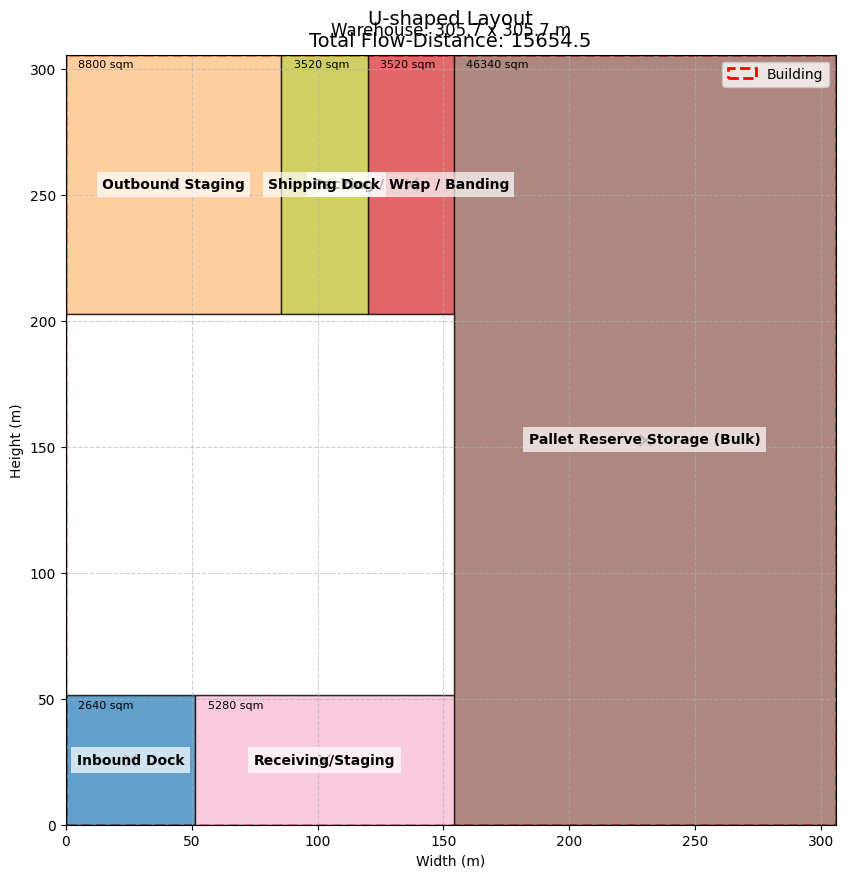

In [23]:

selected_depts= load_data()
# -----------------------------
# USER PARAMETERS / INPUTS
# -----------------------------
# Department areas (sq_m) - scaled down by factor of 10 for more reasonable dimensions
L_LB = {d: 1.0 for d in selected_depts}
W_LB = {d: 1.0 for d in selected_depts}
R = 3  # Aspect ratio tolerance (1.2 means 1:1.2 to 1.2:1)
I = 4
BIG_M = 10000.0  # Big-M for separation constraints

# Calculate total area
total_area = sum(departments[d] for d in selected_depts)

def solve_layout(layout_type ,total_area=total_area):

    model = gp.Model(f"warehouse_layout_{layout_type}")
    model.Params.NonConvex = 2

    # Variables
    alpha, beta = {}, {}
    x_left, x_right, y_bottom, y_top = {}, {}, {}, {}
    width, height = {}, {}  
    d_alpha = {}
    d_beta = {}
    z_x = {}
    z_y = {}
    B_width = model.addVar(lb=0, name="B_width")   # small lb to avoid zero
    B_height = model.addVar(lb=0, name="B_height")

    if layout_type == "L-shaped" or layout_type == "U-shaped":
        selected_depts.append("Phantom")
        departments["Phantom"] = total_area / 3 
        numeric_departments_matrix["Phantom"] = {d: 0 for d in selected_depts}
        for d in selected_depts:
            numeric_departments_matrix[d]["Phantom"] = 0

    for i in selected_depts:
        x_left[i] = model.addVar(lb=0, name=f"x_left_{i}")
        y_bottom[i] = model.addVar(lb=0, name=f"y_bottom_{i}")
        width[i] = model.addVar(lb=0, name=f"width_{i}")
        height[i] = model.addVar(lb=0, name=f"height_{i}")

        # Derived boundaries
        x_right[i] = model.addVar(lb=0, name=f"x_right_{i}")
        y_top[i] = model.addVar(lb=0, name=f"y_top_{i}")
        alpha[i] = model.addVar(name=f"alpha_{i}")
        beta[i] = model.addVar(name=f"beta_{i}")
        # ensure nested dict entries exist
        d_alpha.setdefault(i, {})
        d_beta.setdefault(i, {})
        z_x.setdefault(i, {})
        z_y.setdefault(i, {})
        for j in selected_depts:
            print(i, j)
            d_alpha[i][j] = model.addVar(lb=0, name=f"d_alpha_{i}_{j}")
            d_beta[i][j] = model.addVar(lb=0, name=f"d_beta_{i}_{j}")
            z_x[i][j] = model.addVar(vtype=GRB.BINARY, name=f"z_x_{i}_{j}")
            z_y[i][j] = model.addVar(vtype=GRB.BINARY, name=f"z_y_{i}_{j}")

    model.update()

    # Placement, dimension & area constraints
    for i in selected_depts:
        # Within building
        model.addConstr(alpha[i] >= 0, name=f"alpha_pos_{i}")
        model.addConstr(beta[i] >= 0, name=f"beta_pos_{i}")
        model.addConstr(x_right[i] >= 0, name=f"width_lb_{i}")
        model.addConstr(x_left[i] >= 0, name=f"x_left_pos_{i}")
        model.addConstr(y_top[i] >= 0, name=f"y_top_pos_{i}")
        model.addConstr(y_bottom[i] >= 0, name=f"y_bottom_pos_{i}")
        model.addConstr(x_right[i] <= B_width, name=f"x_right_pos_{i}")
        model.addConstr(y_top[i] <= B_height, name=f"y_top_pos_{i}")

        # Area (bilinear but with positive factors only)
        area = departments[i]
        if i == "Phantom":
            model.addConstr((x_right[i] - x_left[i]) * (y_top[i] - y_bottom[i]) >= 1 * area, name=f"area_lb_{i}")
        else:
            model.addConstr((x_right[i] - x_left[i]) * (y_top[i] - y_bottom[i]) == 1 * area, name=f"area_lb_{i}")

        # Area Constraint (upper bound)
        model.addConstr((x_right[i]-x_left[i])  <= R *(y_top[i]-y_bottom[i]), name=f"area_ub_{i}")
        model.addConstr((y_top[i]-y_bottom[i])  <= R *(x_right[i]-x_left[i]), name=f"area_ub_{i}")

        # Centroids
        model.addConstr(alpha[i] == 0.5 * (x_left[i] + x_right[i]), name=f"centroid_x_{i}")
        model.addConstr(beta[i] == 0.5 * (y_bottom[i] + y_top[i]), name=f"centroid_y_{i}")
       
        for j in selected_depts:
            if i <= j:
                model.addConstr(z_x[i][j] + z_x[j][i] + z_y[i][j] + z_y[j][i] >= 1, name=f"mutual_excl_{i}_{j}")
            if i != j: 
                model.addConstr(x_right[j] <= x_left[i] + BIG_M*(1 - z_x[i][j]), name=f"width_def_{i}_{j}")
                model.addConstr(y_top[j] <= y_bottom[i] + BIG_M*(1 - z_y[i][j]), name=f"height_def_{i}_{j}")
                # Absolute distance linearization
                model.addConstr(d_alpha[i][j] >=  alpha[i] - alpha[j])
                model.addConstr(d_alpha[i][j] >= -alpha[i] + alpha[j])
                model.addConstr(d_beta[i][j]  >=  beta[i]  - beta[j])
                model.addConstr(d_beta[i][j]  >= -beta[i]  + beta[j])
                
    #space specific constraints
    if layout_type == "I-shaped":
        # Inbound dock at bottom
        # Inbound dock must be at the left wall
        model.addConstr(x_left["Inbound Dock"] == 0, name="inbound_left_wall")

        # Outbound dock must be at the right wall
        model.addConstr(x_right["Outbound Staging"] == B_width, name="outbound_right_wall")
        model.addConstr(B_width <= I * B_height)
        model.addConstr(B_height <= I * B_width)
        #total_area = total_area * 1

    if layout_type == "L-shaped":
        # Inbound dock at bottom left corner
        model.addConstr(x_left["Inbound Dock"] == 0, name="inbound_left_wall")
        # Outbound dock at top right corner
        model.addConstr(x_right["Outbound Staging"] == B_width, name="outbound_right_wall")
        # phantom department at bottom wall
        model.addConstr((x_right["Phantom"] - x_left["Phantom"]) >= 1/4 * B_width, name="inbound_width")
        model.addConstr((y_top["Phantom"] - y_bottom["Phantom"]) >= 1/4 * B_height, name="inbound_height")
        model.addConstr(x_left["Phantom"] == 0, name="inbound_left_wall")
        model.addConstr(y_bottom["Phantom"] == 0, name="inbound_bottom_wall")
    if layout_type == "U-shaped":
        # Inbound dock at bottom left corner
        model.addConstr(y_bottom["Inbound Dock"] == 0, name="inbound_bottom_wall")
        model.addConstr(x_left["Inbound Dock"] == 0, name="inbound_left_wall")
        # Outbound dock at top left corner
        model.addConstr(y_top["Outbound Staging"] == B_height, name="outbound_top_wall")
        model.addConstr(x_left["Outbound Staging"] == 0, name="outbound_left_wall")
        # phantom department at left wall
        model.addConstr(x_left["Phantom"] == 0, name="phantom_left_wall")
        model.addConstr(B_width  >=  x_right["Phantom"]+1, name="phantom_right")
        model.addConstr((x_right["Phantom"] - x_left["Phantom"]) >= 1/4 * B_width, name="inbound_width")
        model.addConstr((y_top["Phantom"] - y_bottom["Phantom"]) >= 1/4 * B_height, name="inbound_height")

    total_area = sum(departments[d] for d in selected_depts)
    
    model.addConstr(B_width * B_height == total_area, name="total_area")
    # Objective
    obj = gp.quicksum(
        numeric_departments_matrix[i][j] * (d_alpha[i][j] + d_beta[i][j])
        for i in selected_depts for j in selected_depts if i != j
    )
    model.setObjective(obj, GRB.MINIMIZE)

    model.optimize()

    # Plot results (unchanged except width/height already consistent)
    if model.status in (GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.SUBOPTIMAL):
        print(f"\n--- {layout_type.upper()} LAYOUT ---")
        print(f"Building dimensions: {B_width.X:.1f} x {B_height.X:.1f} m")
        print(f"Total area: {B_width.X * B_height.X:.1f} sqm")
        print(f"Objective (total flow-distance): {model.ObjVal:.1f}")

        # ...existing code inside solve_layout, in the plotting section after creating fig, ax ...
        fig, ax = plt.subplots(figsize=(15,10))
        colors = plt.cm.get_cmap('tab20', len(selected_depts))

        # Warehouse (building) outline
        building_outline = patches.Rectangle(
            (0, 0),
            B_width.X,
            B_height.X,
            facecolor='none',
            edgecolor='red',
            linewidth=2,
            linestyle='--',
            label='Building'
        )
        ax.add_patch(building_outline)
        ax.text(B_width.X/2, B_height.X + 0.02*B_height.X,
                f"Warehouse: {B_width.X:.1f} x {B_height.X:.1f} m",
                ha='center', va='bottom', fontsize=12)

        for idx, i in enumerate(selected_depts):
            xl, xr = x_left[i].X, x_right[i].X
            yb, yt = y_bottom[i].X, y_top[i].X
            
            # Check if the department is Phantom
            if i == "Phantom":
                facecolor = 'white'
                label_text = ""  # no name
                show_marker = False
                show_area = False
            else:
                facecolor = colors(idx)
                label_text = i
                show_marker = True
                show_area = True
            
            rect = patches.Rectangle((xl, yb), xr - xl, yt - yb,
                                    edgecolor='black', facecolor=facecolor, alpha=0.7)
            ax.add_patch(rect)
            
            # Add department name
            if label_text:
                ax.text((xl + xr)/2, (yb + yt)/2, label_text, ha='center', va='center',
                        fontsize=10, fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
            
            # Add marker if not Phantom
            if show_marker:
                ax.plot((xl + xr)/2, (yb + yt)/2, 'kx', markersize=8)
            
            # Add area text if not Phantom
            if show_area:
                ax.text(xl + 5, yt - 5, f"{(xr - xl)*(yt - yb):.0f} sqm", fontsize=8)

        ax.set_xlim(0, B_width.X)
        ax.set_ylim(0, B_height.X)
        ax.set_aspect('equal')
        ax.set_title(f"{layout_type} Layout\nTotal Flow-Distance: {model.ObjVal:.1f}", fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_xlabel("Width (m)")
        ax.set_ylabel("Height (m)")
        ax.legend(loc='upper right')
        plt.show()

    else:
        print(f"No feasible solution for {layout_type}, status: {model.status}")

# Run for all layouts
for layout_type in ["U-shaped"]:
    solve_layout(layout_type, total_area=total_area)


In [12]:
# Print the quantified interaction values between departments
for dept_from in selected_depts:
    print(f"{dept_from}:")
    for dept_to in selected_depts:
        value = numeric_departments_matrix[dept_from][dept_to]
        print(f"  {dept_to}: {value}")
    print()

Inbound Dock:
  Inbound Dock: 0
  Outbound Staging: 0
  Packing / Wrap / Banding: 0
  Pallet Reserve Storage (Bulk): 0
  Receiving/Staging: 9
  Shipping Dock: 0
  Phantom: 0

Outbound Staging:
  Inbound Dock: 0
  Outbound Staging: 0
  Packing / Wrap / Banding: 9
  Pallet Reserve Storage (Bulk): 0
  Receiving/Staging: 0
  Shipping Dock: 9
  Phantom: 0

Packing / Wrap / Banding:
  Inbound Dock: 0
  Outbound Staging: 9
  Packing / Wrap / Banding: 0
  Pallet Reserve Storage (Bulk): 9
  Receiving/Staging: 0
  Shipping Dock: 0
  Phantom: 0

Pallet Reserve Storage (Bulk):
  Inbound Dock: 0
  Outbound Staging: 0
  Packing / Wrap / Banding: 9
  Pallet Reserve Storage (Bulk): 0
  Receiving/Staging: 4
  Shipping Dock: 0
  Phantom: 0

Receiving/Staging:
  Inbound Dock: 9
  Outbound Staging: 0
  Packing / Wrap / Banding: 0
  Pallet Reserve Storage (Bulk): 4
  Receiving/Staging: 0
  Shipping Dock: 0
  Phantom: 0

Shipping Dock:
  Inbound Dock: 0
  Outbound Staging: 9
  Packing / Wrap / Banding: 0
  

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# -----------------------------
# USER PARAMETERS / INPUTS
# -----------------------------
selected_depts = load_data()


R = 3  # Aspect ratio tolerance (1:1 to R:1)
BIG_M = 10000.0

# Precompute width/height options
def compute_wh_options(area, R, num_options=5):
    w_min = np.sqrt(area / R)
    w_max = np.sqrt(area * R)
    widths = np.linspace(w_min, w_max, num_options)
    heights = area / widths
    return list(zip(widths, heights))

wh_options = {d: compute_wh_options(departments[d], R) for d in selected_depts}

# -----------------------------
# SOLVER
# -----------------------------
def solve_layout_linear(selected_depts):
    model = gp.Model("linear_warehouse_layout")

    # Variables
    x_left, y_bottom, width, height = {}, {}, {}, {}
    alpha, beta = {}, {}
    z_x, z_y = {}, {}
    dx, dy = {}, {}

    # Dimension selection variables
    wh_sel = {}

    # Building dimensions
    B_width = model.addVar(lb=0, name="B_width")
    B_height = model.addVar(lb=0, name="B_height")

    # Create variables for each department
    for i in selected_depts:
        x_left[i] = model.addVar(lb=0, name=f"x_left_{i}")
        y_bottom[i] = model.addVar(lb=0, name=f"y_bottom_{i}")
        alpha[i] = model.addVar(name=f"alpha_{i}")
        beta[i] = model.addVar(name=f"beta_{i}")

        # Width/height selection
        wh_sel[i] = []
        for k, (w, h) in enumerate(wh_options[i]):
            sel = model.addVar(vtype=GRB.BINARY, name=f"wh_sel_{i}_{k}")
            wh_sel[i].append(sel)
        width[i] = model.addVar(lb=0, name=f"width_{i}")
        height[i] = model.addVar(lb=0, name=f"height_{i}")

    # Non-overlap binaries
    for i in selected_depts:
        z_x[i], z_y[i] = {}, {}
        for j in selected_depts:
            if i != j:
                z_x[i][j] = model.addVar(vtype=GRB.BINARY, name=f"z_x_{i}_{j}")
                z_y[i][j] = model.addVar(vtype=GRB.BINARY, name=f"z_y_{i}_{j}")
                dx[i,j] = model.addVar(lb=0, name=f"dx_{i}_{j}")
                dy[i,j] = model.addVar(lb=0, name=f"dy_{i}_{j}")

    model.update()

    # -----------------------------
    # Constraints
    # -----------------------------
    for i in selected_depts:
        # Dimension selection constraints
        model.addConstr(sum(wh_sel[i]) == 1, name=f"select_one_wh_{i}")
        model.addConstr(width[i] == gp.quicksum(wh_options[i][k][0]*wh_sel[i][k] for k in range(len(wh_sel[i]))))
        model.addConstr(height[i] == gp.quicksum(wh_options[i][k][1]*wh_sel[i][k] for k in range(len(wh_sel[i]))))

        # Within building
        model.addConstr(x_left[i] + width[i] <= B_width)
        model.addConstr(y_bottom[i] + height[i] <= B_height)
        model.addConstr(alpha[i] == x_left[i] + 0.5*width[i])
        model.addConstr(beta[i] == y_bottom[i] + 0.5*height[i])

    # Non-overlap constraints
    for i in selected_depts:
        for j in selected_depts:
            if i < j:
                model.addConstr(x_left[i] + width[i] <= x_left[j] + BIG_M*(1 - z_x[i][j]))
                model.addConstr(x_left[j] + width[j] <= x_left[i] + BIG_M*z_x[i][j])
                model.addConstr(y_bottom[i] + height[i] <= y_bottom[j] + BIG_M*(1 - z_y[i][j]))
                model.addConstr(y_bottom[j] + height[j] <= y_bottom[i] + BIG_M*z_y[i][j])
                model.addConstr(z_x[i][j] + z_y[i][j] >= 1)

    # Manhattan distance constraints for objective
    for i in selected_depts:
        for j in selected_depts:
            if i != j:
                model.addConstr(dx[i,j] >= alpha[i] - alpha[j])
                model.addConstr(dx[i,j] >= alpha[j] - alpha[i])
                model.addConstr(dy[i,j] >= beta[i] - beta[j])
                model.addConstr(dy[i,j] >= beta[j] - beta[i])

    # Example: Inbound Dock left wall, Outbound right wall
    model.addConstr(x_left["Inbound Dock"] == 0)
    model.addConstr(x_left["Outbound Staging"] + width["Outbound Staging"] == B_width)

    # Total area constraints (approximate)
    model.addConstr(B_width >= sum(width[i] for i in selected_depts))
    model.addConstr(B_height >= sum(height[i] for i in selected_depts))

    # -----------------------------
    # Objective: minimize total flow-distance
    # -----------------------------
    obj = gp.quicksum(numeric_departments_matrix[i][j] * (dx[i,j] + dy[i,j])
                      for i in selected_depts for j in selected_depts if i != j)
    model.setObjective(obj, GRB.MINIMIZE)

    model.optimize()

    # -----------------------------
    # Plot results
    # -----------------------------
    if model.status in (GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.SUBOPTIMAL):
        print(f"Building dimensions: {B_width.X:.1f} x {B_height.X:.1f}")
        print(f"Objective: {model.ObjVal:.1f}")
        fig, ax = plt.subplots(figsize=(12,8))
        colors = plt.cm.get_cmap('tab20', len(selected_depts))
        # Building outline
        ax.add_patch(patches.Rectangle((0,0), B_width.X, B_height.X, fill=False, edgecolor='red', linewidth=2))
        for idx, i in enumerate(selected_depts):
            xl, yb = x_left[i].X, y_bottom[i].X
            w, h = width[i].X, height[i].X
            rect = patches.Rectangle((xl, yb), w, h, facecolor=colors(idx), edgecolor='black', alpha=0.7)
            ax.add_patch(rect)
            ax.text(xl + w/2, yb + h/2, i, ha='center', va='center', fontsize=10)
        ax.set_xlim(0, B_width.X)
        ax.set_ylim(0, B_height.X)
        ax.set_aspect('equal')
        plt.show()
    else:
        print("No feasible solution found")

# Run solver
solve_layout_linear(selected_depts)
